# Imbalanced Data and SMOTE

An investigation into imbalanced data and the use of Synthetic Minority Oversampling Technique (SMOTE) to address class imbalance using Credit Card Fraud Detection data. Data obtained from:

https://www.kaggle.com/mlg-ulb/creditcardfraud

For details of the data see above link. The data also consists of a `Time` column that is not relevant for this analysis and will be dropped. `Class` is the response variable and indicates if a transaction is fradulent or not.

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('data/creditcard.csv')

# Drop duplicates and Time column
df.drop_duplicates(inplace=True)
df.drop('Time', axis=1, inplace=True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Check distribution of Class
fraud = df['Class'].value_counts()
total = df.shape[0]

print(f'There are {fraud[0]} normal transactions and {fraud[1]} fraudulent transactions.')
print(f'{fraud[1]/total*100:.2f}% of total transactions were fraudulent')

There are 283253 normal transactions and 473 fraudulent transactions.
0.17% of total transactions were fraudulent


Summary:
* Less than 0.5% of data is classified as fraudulent
* Note `Amount` appears to not be normalised here. Should normalise prior to modelling

Extreme class imbalance is common in fraud detection since a majority of transactions are legitimate. Let's attempt to model this data using logistic regression without any manipulation.

## Logistic Regression with Original Data

In [4]:
X = df.drop('Class', axis=1)
y = df['Class']

In [5]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalise Amount column
scaler = StandardScaler()
X_train['Amount'] = scaler.fit_transform(X_train['Amount'].values.reshape(-1, 1))
X_test['Amount'] = scaler.transform (X_test['Amount'].values.reshape(-1, 1))

Some comments:

The `StandardScaler` computes and mean and standard deviation to normalise the columns. The scaler should be fit onto the training data before using it to standardise both training and testing sets. This prevents information from the testing set being used as part of model fitting for training data i.e. it won't influence the mean and standard deviation used to perform the transform. In general, the testing set should not be used anywhere as part of model fitting.

Accuracy score: 0.999
Precision score: 0.891
Recall score: 0.544


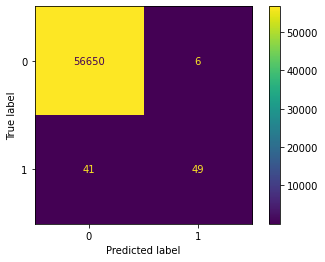

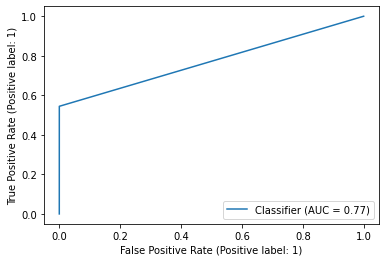

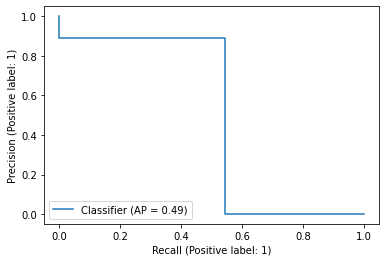

In [6]:
# Model Fit
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Model Evaluation
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test,y_pred)
print(f'Accuracy score: {acc:.3f}')
print(f'Precision score: {precision:.3f}')
print(f'Recall score: {recall:.3f}')

matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(matrix).plot()
RocCurveDisplay.from_predictions(y_test, y_pred)
PrecisionRecallDisplay.from_predictions(y_test, y_pred)

Observations:
* Accuracy is misleading when dealing with imbalanced data. Most of the accuracy score is attributed to the vast amount of `0`s in the data. If we have a model that predicts every observation as `0` or not fraudulent then this model will still have high accuracy but will not be useful for detecting fraud
* Need to use other metrics such as precision, recall, f1 or other visualisations e.g. AUC-ROC, AUPRC

## Logistic Regression with SMOTE Data

Note: Oversampling is only applied to the training data to avoid adding synthetic data to testing set. The level of oversampling is determined by the `sampling_strategy` argument in `SMOTE` which defaults to equal proportion of majority and minority class.

In [7]:
X = df.drop('Class', axis=1)
y = df['Class']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

total_train = len(y_train)
total_train_sm = len(y_train_sm)
fraud_train = sum(y_train == 1)
fraud_train_sm = sum(y_train_sm == 1)

print(f'Before SMOTE, proportion of training data classed as fraudulent: {fraud_train/total_train*100:.2f}%')
print(f'After SMOTE, proportion of training data classed as fraudulent: {fraud_train_sm/total_train_sm*100:.2f}%')

Before SMOTE, proportion of training data classed as fraudulent: 0.17%
After SMOTE, proportion of training data classed as fraudulent: 50.00%


Accuracy score: 0.982
Precision score: 0.072
Recall score: 0.867


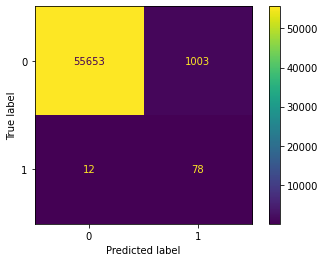

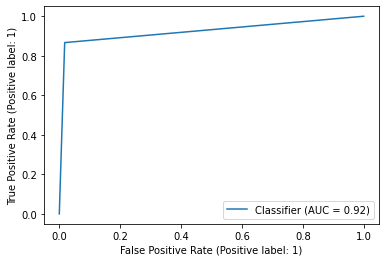

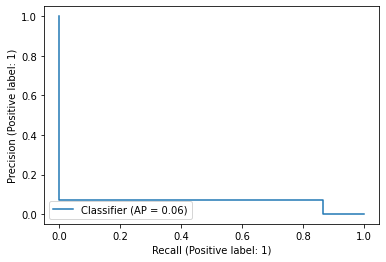

In [9]:
# Normalise Amount column
scaler = StandardScaler()
X_train_sm['Amount'] = scaler.fit_transform(X_train_sm['Amount'].values.reshape(-1, 1))
X_test['Amount'] = scaler.transform (X_test['Amount'].values.reshape(-1, 1))

# Model Fit
lr = LogisticRegression()
lr.fit(X_train_sm, y_train_sm)
y_pred = lr.predict(X_test)

# Model Evaluation
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test,y_pred)
print(f'Accuracy score: {acc:.3f}')
print(f'Precision score: {precision:.3f}')
print(f'Recall score: {recall:.3f}')

matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(matrix).plot()
RocCurveDisplay.from_predictions(y_test, y_pred)
PrecisionRecallDisplay.from_predictions(y_test, y_pred)

Observations:
* Oversampling trades precision for recall, leading to more True Positives and False Positives
* There is an additional hyperparameter `sampling_strategy` to be tuned

Either method can be considered depending on what is required:
* The model without oversampling ensures that any predicted frauds are very likely to be actually fraudulent (higher precision). It is more useful when considering the limited resources available for further investigation into the transactions. If every predicted positives were checked, the oversampled data will result in a large number of investigations turning up negative, which may be a waste of resources. 
* The model using SMOTE ensures that most truly fradulent transactions are identified (higher recall). It is more useful when the emphasis is on identification of positive class and in cases where False Negatives are detrimental e.g. terminal illness.

Next Steps:
* Cross Validation techniques using SMOTE